#**GetAround Project:**

The dataset contains the following columns:

- rental_id: Unique identifier for each rental (int)
- car_id: Unique identifier for each car (int)
- checkin_type:
      - mobile = rental agreement signed on the owner's smartphone
      - connect = car equiped with the Connect technology , opened by the driver with his smartphone.
- state:
      - canceled means that the rental did not happen (was canceled by the driver or the owner)
      - ended
- delay_at_checkout_in_minutes:
      - Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
- previous_ended_rental_id:
      - id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
- time_delta_with_previous_rental_in_minutes:
      - Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)

# ----- Import Libraries -----

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('ggplot')

#----- Load Dataset -----

In [4]:
df = pd.read_excel('/content/get_around_delay_analysis.xlsx')

#----- EDA -----

In [5]:
# Basic information about the dataset
display(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


None

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


##----- Quick overview of the dataset: basic statistics, missing values, duplicates -----


In [19]:
# Basic statistics
print('Basic statistics:\n')
display(df.describe(include='all'))

# Checking for any missing values
missing_values = df.isnull().sum() / len(df) * 100
print('\nMissing values:', missing_values)

# Distribution of rental states
state_counts = df['state'].value_counts()
print('\nDistribution of rental states:', state_counts)

# Distribution of check-in types
checkin_counts = df['checkin_type'].value_counts()
print('\nDistribution of check-in types:', checkin_counts)

# Delay stats
delay_stats = df['delay_at_checkout_in_minutes'].describe()
print('\nDelay stats:')
display(delay_stats)

# Check for duplicates
duplicates_count = df.duplicated().sum()
print('\nDuplicates:', duplicates_count)

Basic statistics:



,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000



Missing values: rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

Distribution of rental states: state
ended       18045
canceled     3265
Name: count, dtype: int64

Distribution of check-in types: checkin_type
mobile     17003
connect     4307
Name: count, dtype: int64

Delay stats:


,delay_at_checkout_in_minutes
count,16346.000000
mean,59.701517
std,1002.561635
min,-22433.000000
25%,-36.000000
50%,9.000000
75%,67.000000
max,71084.000000



Duplicates: 0


##----- Visualization: Distribution of dataset-----

<Axes: title={'center': 'Check-in Type Distribution'}, ylabel='Count'>

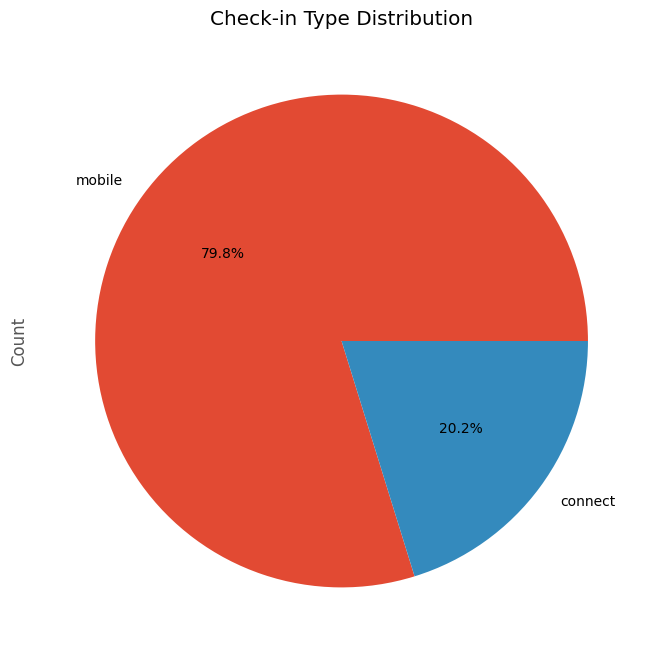

In [52]:
# Distribution of check-in types
df['checkin_type'].value_counts().plot(
    kind='pie',
    title='Check-in Type Distribution',
    xlabel='Check-in Type',
    ylabel='Count',
    figsize=(14, 8),
    autopct='%1.1f%%'
)

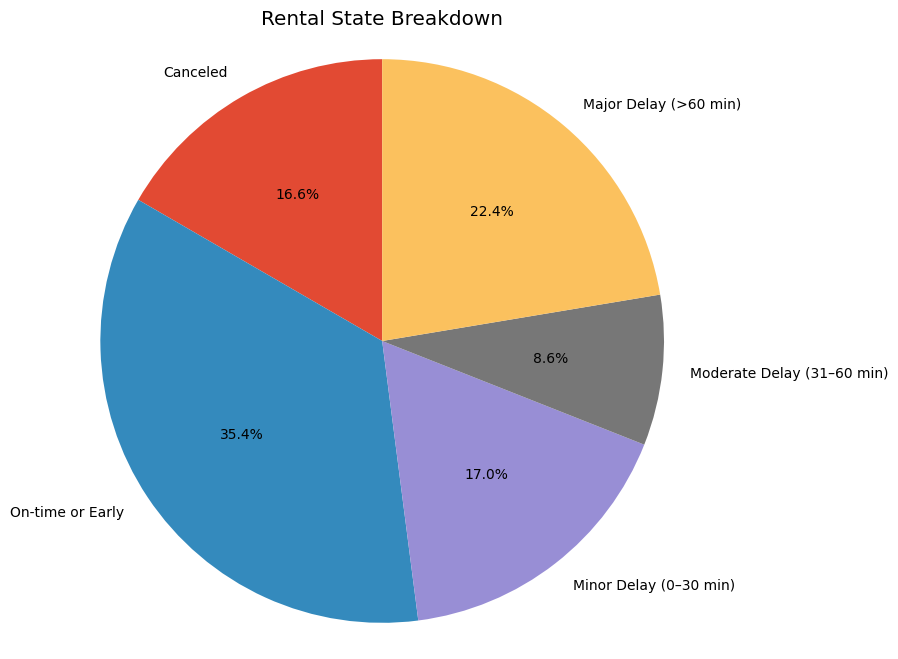

In [43]:
# Distribution of rental states
canceled = df[df['state'] == 'canceled']
ended = df[df['state'] == 'ended']

on_time = ended[ended['delay_at_checkout_in_minutes'] <= 0]
minor_delay = ended[(ended['delay_at_checkout_in_minutes'] > 0) & (ended['delay_at_checkout_in_minutes'] <= 30)]
moderate_delay = ended[(ended['delay_at_checkout_in_minutes'] > 30) & (ended['delay_at_checkout_in_minutes'] <= 60)]
major_delay = ended[ended['delay_at_checkout_in_minutes'] > 60]

labels = ['Canceled', 'On-time or Early', 'Minor Delay (0–30 min)', 'Moderate Delay (31–60 min)', 'Major Delay (>60 min)']
sizes = [
    len(canceled),
    len(on_time),
    len(minor_delay),
    len(moderate_delay),
    len(major_delay)
]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Rental State Breakdown')
plt.axis('equal')
plt.show()

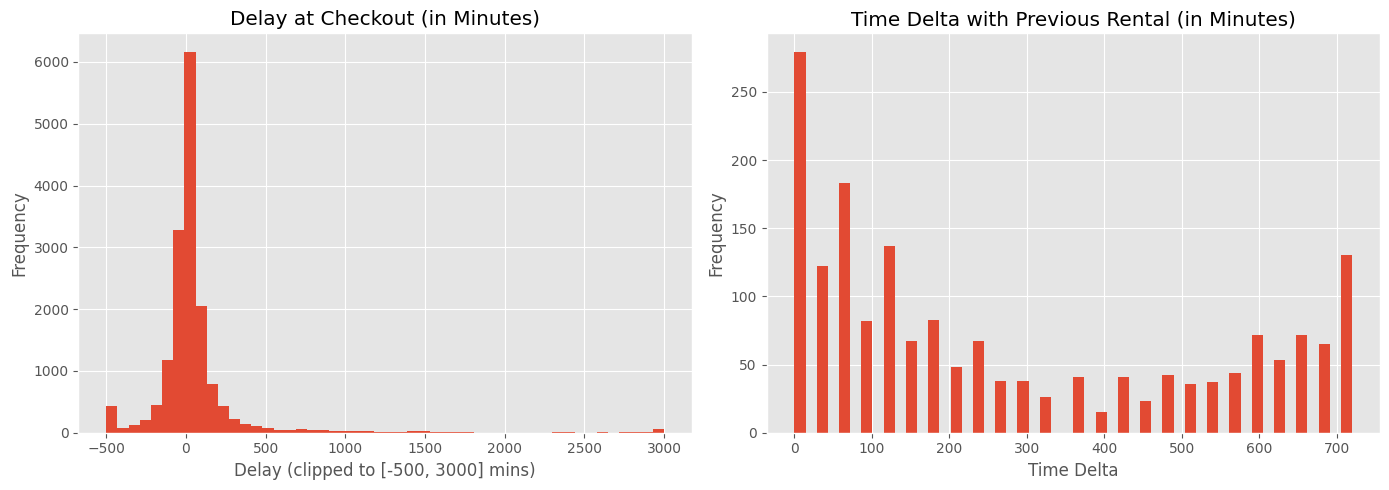

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

plots =[{
        'data': df['delay_at_checkout_in_minutes'].clip(-500, 3000),
        'kind': 'hist',
        'ax': axs[0],
        'title': 'Delay at Checkout (in Minutes)',
        'xlabel': 'Delay (clipped to [-500, 3000] mins)',
        'ylabel': 'Frequency'
    },
    {
        'data': df['time_delta_with_previous_rental_in_minutes'].dropna(),
        'kind': 'hist',
        'ax': axs[1],
        'title': 'Time Delta with Previous Rental (in Minutes)',
        'xlabel': 'Time Delta',
        'ylabel': 'Frequency'
    }

]

# Plot loop
for plot in plots:
  plot['ax'].hist(plot['data'], bins=50)
  plot['ax'].set_title(plot['title'])
  plot['ax'].set_xlabel(plot['xlabel'])
  plot['ax'].set_ylabel(plot['ylabel'])

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

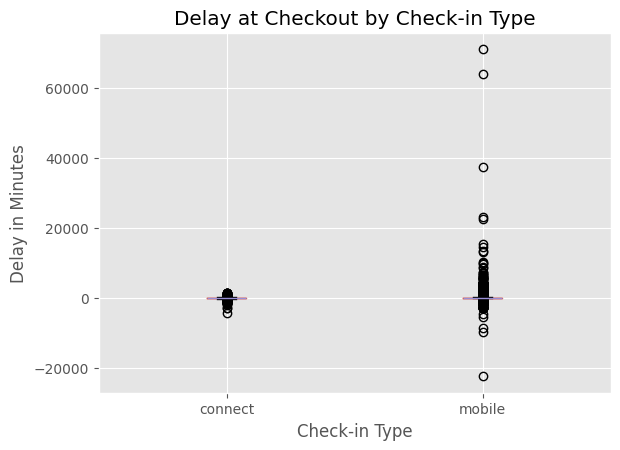

In [83]:
# Delay by Check-in Type to check outliers
plt.figure(figsize=(10, 8))
ended.boxplot(column='delay_at_checkout_in_minutes', by='checkin_type')
plt.title('Delay at Checkout by Check-in Type')
plt.suptitle('')
plt.xlabel('Check-in Type')
plt.ylabel('Delay in Minutes')
plt.grid(True)
plt.show()

##EDA summary of the dataset:

The dataset contains a total of 21, 310 rentals and 18, 045 are completed (ended) while there have been 3, 265 canceled rentals. There are two check-in types available and most drivers check-in using the mobile type with a total of 14, 326 (67% of the total rentals) and others check-in with connect type with 6, 984 (33%).

Delay at Checkout: The median delay is about 9 minutes while 75% of delays are under 67 minutes. Some extreme delays exist (min: -22,433 mins, max: 71,084 mins), so the histogram range has been clipped for better visualization. This is confirmed by the boxplot, showing outliers in Mobile cars.

Time Delta Between Rentals (when available): There are only 1,841 rentals that have a preceding rental on the same car. The average time interval are about 180 minutes (3 hours) and 25% of cases had less than 60 minutes between rentals.

## ----- Summary statistics for delay and time delta for each check-in type and the visualization. -----  
- *Note: Null values have been dropped for the visualization*
- *The mean  is the red dashed and the median is green dotted lines added to the histograms.*

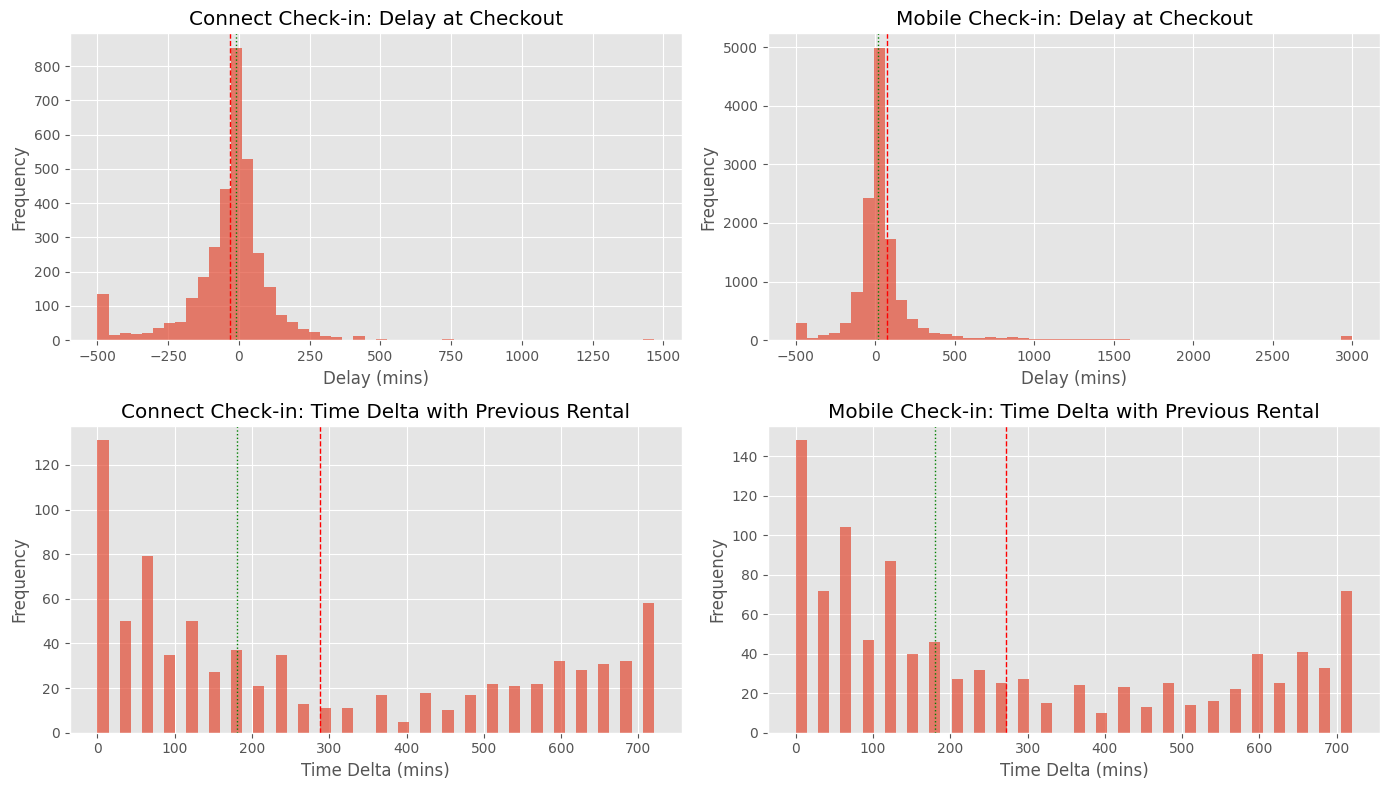

,Check-in Type,Total Rentals,Ended Rentals,Delay Mean,Delay Median,Time Delta Mean,Time Delta Median
0,Connect,4307,3509,-31.10,-9.0,287.68,180.0
1,Mobile,17003,14536,74.57,14.0,272.66,180.0


In [16]:
# Define parameters for clipping
delay_clip = (-500, 3000)
delta_clip = (0, 720)

# Target check-in types
checkin_labels = ['connect', 'mobile']
label_map = {'connect': 'Connect', 'mobile': 'Mobile'}

checkin_types = {}
summary_stats = []

for checkin in checkin_labels:
    subset = df[df['checkin_type'] == checkin]
    label = label_map[checkin]

    delay = subset['delay_at_checkout_in_minutes'].dropna().clip(*delay_clip)
    delta = subset['time_delta_with_previous_rental_in_minutes'].dropna().clip(*delta_clip)

    checkin_types[label] = {'delay': delay, 'delta': delta}

    summary_stats.append({
        'Check-in Type': label,
        'Total Rentals': subset.shape[0],
        'Ended Rentals': subset[subset['state'] == 'ended'].shape[0],
        'Delay Mean': round(delay.mean(), 2),
        'Delay Median': round(delay.median(), 2),
        'Time Delta Mean': round(delta.mean(), 2),
        'Time Delta Median': round(delta.median(), 2)
    })

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for idx, (label, data) in enumerate(checkin_types.items()):

    axs[0, idx].hist(data['delay'], bins=50, alpha=0.7)
    axs[0, idx].axvline(data['delay'].mean(), color='red', linestyle='dashed', linewidth=1)
    axs[0, idx].axvline(data['delay'].median(), color='green', linestyle='dotted', linewidth=1)
    axs[0, idx].set_title(f'{label} Check-in: Delay at Checkout')
    axs[0, idx].set_xlabel('Delay (mins)')
    axs[0, idx].set_ylabel('Frequency')


    axs[1, idx].hist(data['delta'], bins=50, alpha=0.7)
    axs[1, idx].axvline(data['delta'].mean(), color='red', linestyle='dashed', linewidth=1)
    axs[1, idx].axvline(data['delta'].median(), color='green', linestyle='dotted', linewidth=1)
    axs[1, idx].set_title(f'{label} Check-in: Time Delta with Previous Rental')
    axs[1, idx].set_xlabel('Time Delta (mins)')
    axs[1, idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_stats)
display(summary_df)

# Connect Rentals vs. Mobile  Rentals

- Connect Rentals: The total rentals with this type 4,307  and 3,509 (81%) have been completed which quite good and the delay at checkout average is about -9 mins which means early returns are common. On the other hand 75% of delays are below 32 mins and the time between rentals (for cars with consecutive rentals) is averaging to 180 mins. Therefore 25% of overlaps have less than 60 mins between rentals.

- Mobile Rentals: The rentals with this type is far higher than connect type, which is 17,003 total. Total completed rentals is 14,536 (85%). Regarding the delay at checkout +, the average median is 14 mins which means more late returns. 75% of delays are below 77 mins and based on the table above it went up to 71,084 mins which is very late! The time between rentals is averaging to 180 mins and similar overlap patters as connect type.


Mobile check-ins have more delays and larger late returns whilst Connect cars are more punctual, possibly due to automation or remote access features. Both types have similar time gaps between consecutive rentals.


#----- Check how many next rentals could be affected by late returns from previous rentals -----

In [ ]:
# Rows where we have delay and time_delta values
overlap_df = df[
    (df['state'] == 'ended') &
    df['previous_ended_rental_id'].notna() &
    df['delay_at_checkout_in_minutes'].notna() &
    df['time_delta_with_previous_rental_in_minutes'].notna()
]
# Determine if delay from previous rental would interfere with the next one
overlap_df['next_rental_impacted'] = (
    overlap_df['delay_at_checkout_in_minutes'] > overlap_df['time_delta_with_previous_rental_in_minutes']
)
# Count impacted vs not impacted, overall and by check-in type
overall_impact = overlap_df['next_rental_impacted'].value_counts()
impact_by_checkin = overlap_df.groupby('checkin_type')['next_rental_impacted'].value_counts()

overall_impact, impact_by_checkin

<ipython-input-11-ebd8e93f9d9e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap_df['next_rental_impacted'] = (


(next_rental_impacted
 False    1245
 True      270
 Name: count, dtype: int64,
 checkin_type  next_rental_impacted
 connect       False                   581
               True                     80
 mobile        False                   664
               True                    190
 Name: count, dtype: int64)

##Analysis: Next Rentals affected by Late Returns
- Overall, 17.8 % of rentals with back-to-back bookings were affected by delays which totals to 270 rentals.
- Total cases for each check-in type:
  - Connect: 661 total cases and 12.1% of rentals were affected.
  - Mobile: 854 total cases and 22.2% of rentals were affected.

Mobile rentals are nearly twice as likely to cause a problem due to late returns. This supports the idea of enabling the minimum delay feature at least for Mobile rentals, or using different thresholds per type.

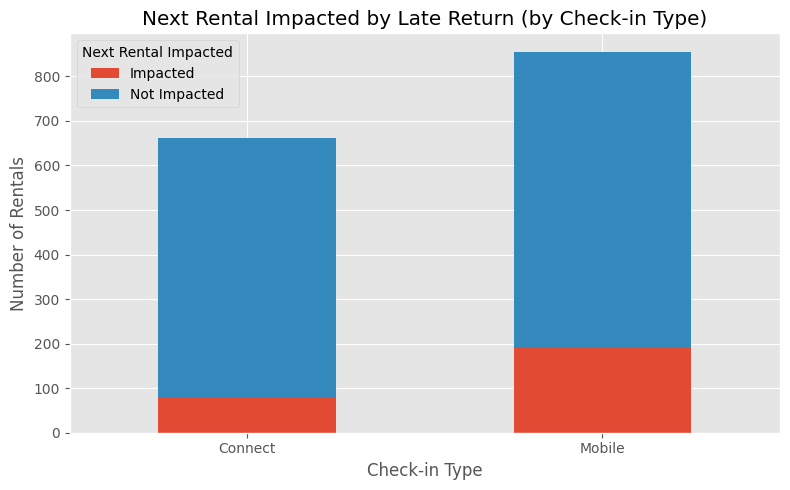

In [ ]:
#Plotting data
impact_summary = {
    'Connect': {'Impacted': 80, 'Not Impacted': 581},
    'Mobile': {'Impacted': 190, 'Not Impacted': 664}
}

impact_df = pd.DataFrame(impact_summary).T
impact_df['Total'] = impact_df['Impacted'] + impact_df['Not Impacted']
impact_df['% Impacted'] = (impact_df['Impacted'] / impact_df['Total']) * 100

# Plot bar chart
impact_df[['Impacted', 'Not Impacted']].plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5))
plt.title('Next Rental Impacted by Late Return (by Check-in Type)')
plt.xlabel('Check-in Type')
plt.ylabel('Number of Rentals')
plt.xticks(rotation=0)
plt.legend(title='Next Rental Impacted')
plt.tight_layout()
plt.show()


#----- Let's simulate how many of these would be "solved" by different minimum delay thresholds [15, 30, 45, 60, 75, 90] -----

In [ ]:
# Define thresholds
thresholds = [15, 30, 45, 60, 75, 90]

# Analyze solved cases by check-in type and threshold
solved_by_type = []

for threshold in thresholds:
    for checkin_type in ['connect', 'mobile']:
        subset = overlap_df[
            (overlap_df['checkin_type'] == checkin_type) &
            (overlap_df['next_rental_impacted']) &
            (overlap_df['delay_at_checkout_in_minutes'] - overlap_df['time_delta_with_previous_rental_in_minutes'] <= threshold)
        ]
        total_issues = overlap_df[
            (overlap_df['checkin_type'] == checkin_type) &
            (overlap_df['next_rental_impacted'])
        ].shape[0]

        solved_by_type.append({
            'checkin_type': checkin_type,
            'threshold_minutes': threshold,
            'solved_cases': subset.shape[0],
            'total_problematic_cases': total_issues,
            'percent_solved': round(100 * subset.shape[0] / total_issues, 2) if total_issues > 0 else 0
        })

solved_by_type_df = pd.DataFrame(solved_by_type)
display(solved_by_type_df)

,checkin_type,threshold_minutes,solved_cases,total_problematic_cases,percent_solved
0,connect,15,12,80,15.00
1,mobile,15,38,190,20.00
2,connect,30,21,80,26.25
3,mobile,30,58,190,30.53
4,connect,45,28,80,35.00
5,mobile,45,76,190,40.00
6,connect,60,44,80,55.00
7,mobile,60,85,190,44.74
8,connect,75,52,80,65.00
9,mobile,75,93,190,48.95


##Plotting the percent of problematic cases solved for each threshold by check-in type

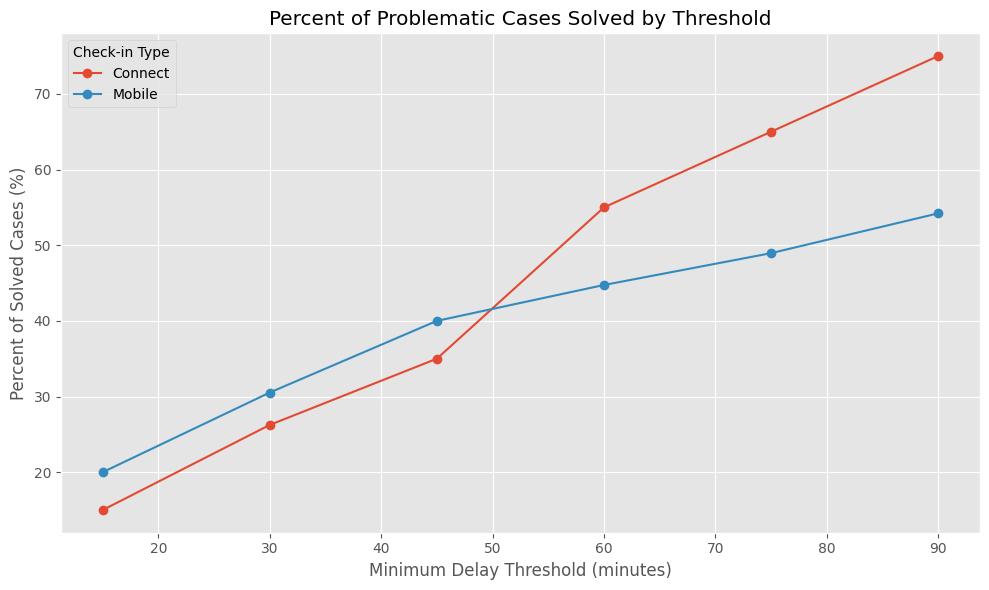

In [ ]:
# Plotting the percent of problematic cases solved for each threshold by check-in type

# Plot with custom colors
plt.figure(figsize=(10, 6))
for checkin_type in solved_by_type_df['checkin_type'].unique():
    subset = solved_by_type_df[solved_by_type_df['checkin_type'] == checkin_type]
    plt.plot(
        subset['threshold_minutes'],
        subset['percent_solved'],
        marker='o',
        label=checkin_type.capitalize()
    )

plt.title('Percent of Problematic Cases Solved by Threshold')
plt.xlabel('Minimum Delay Threshold (minutes)')
plt.ylabel('Percent of Solved Cases (%)')
plt.legend(title='Check-in Type')
plt.grid(True)
plt.tight_layout()
plt.show()

Here’s the visualization showing how each threshold reduces the number of problematic cases for Connect and Mobile check-in types.

You can clearly see that:

- Mobile rentals benefit more from increased thresholds.
- Connect rentals show a smaller but steady improvement.

#----- Exploring the trade-off with revenue -----

,checkin_type,threshold_minutes,blocked_rentals,total_rentals,percent_revenue_at_risk
0,connect,15,109,3509,3.11
1,mobile,15,135,14536,0.93
2,connect,30,109,3509,3.11
3,mobile,30,135,14536,0.93
4,connect,45,156,3509,4.45
5,mobile,45,202,14536,1.39
6,connect,60,156,3509,4.45
7,mobile,60,202,14536,1.39
8,connect,75,221,3509,6.30
9,mobile,75,297,14536,2.04


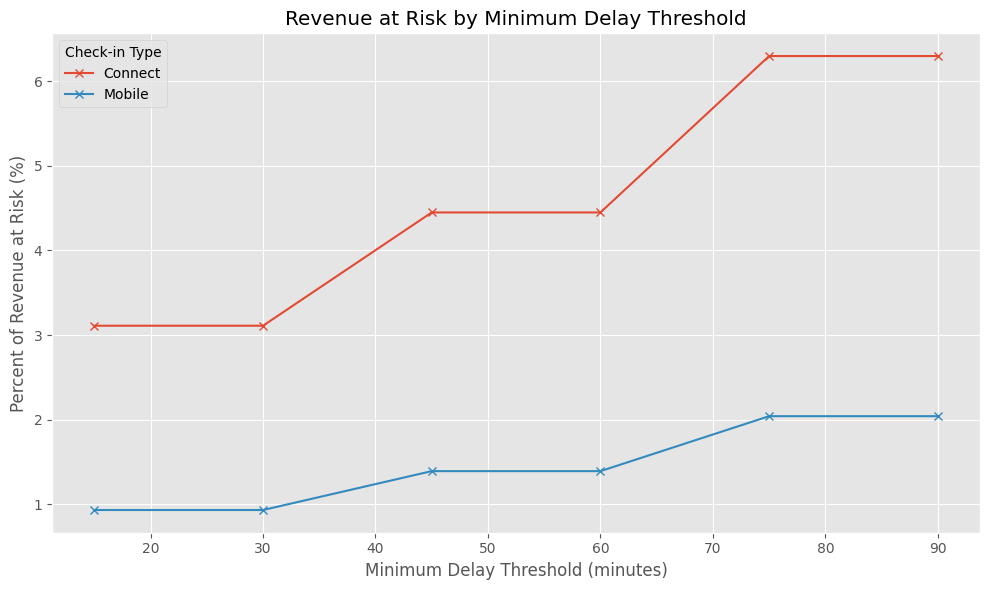

In [ ]:
# Let's calculate how many total ended rentals per check-in type
ended_rentals_by_type = df[df['state'] == 'ended'].groupby('checkin_type')['rental_id'].count()

# For each threshold, calculate potentially blocked rentals (with time delta below threshold)
revenue_impact = []

for threshold in thresholds:
    for checkin_type in ['connect', 'mobile']:
        # Rentals that would be blocked because time delta with previous rental is too short
        blocked = df[
            (df['state'] == 'ended') &
            (df['checkin_type'] == checkin_type) &
            (df['time_delta_with_previous_rental_in_minutes'].notna()) &
            (df['time_delta_with_previous_rental_in_minutes'] < threshold)
        ]

        total_rentals = ended_rentals_by_type[checkin_type]

        revenue_impact.append({
            'checkin_type': checkin_type,
            'threshold_minutes': threshold,
            'blocked_rentals': blocked.shape[0],
            'total_rentals': total_rentals,
            'percent_revenue_at_risk': round(100 * blocked.shape[0] / total_rentals, 2)
        })

revenue_impact_df = pd.DataFrame(revenue_impact)
display(revenue_impact_df)

# Plot revenue at risk by threshold and check-in type
plt.figure(figsize=(10, 6))
for checkin_type in revenue_impact_df['checkin_type'].unique():
    subset = revenue_impact_df[revenue_impact_df['checkin_type'] == checkin_type]
    plt.plot(
        subset['threshold_minutes'],
        subset['percent_revenue_at_risk'],
        marker='x',
        label=checkin_type.capitalize()
    )

plt.title('Revenue at Risk by Minimum Delay Threshold')
plt.xlabel('Minimum Delay Threshold (minutes)')
plt.ylabel('Percent of Revenue at Risk (%)')
plt.legend(title='Check-in Type')
plt.grid(True)
plt.tight_layout()
plt.show()


#----- Comparison plot with the problematic cases solved for better trade-off insight -----

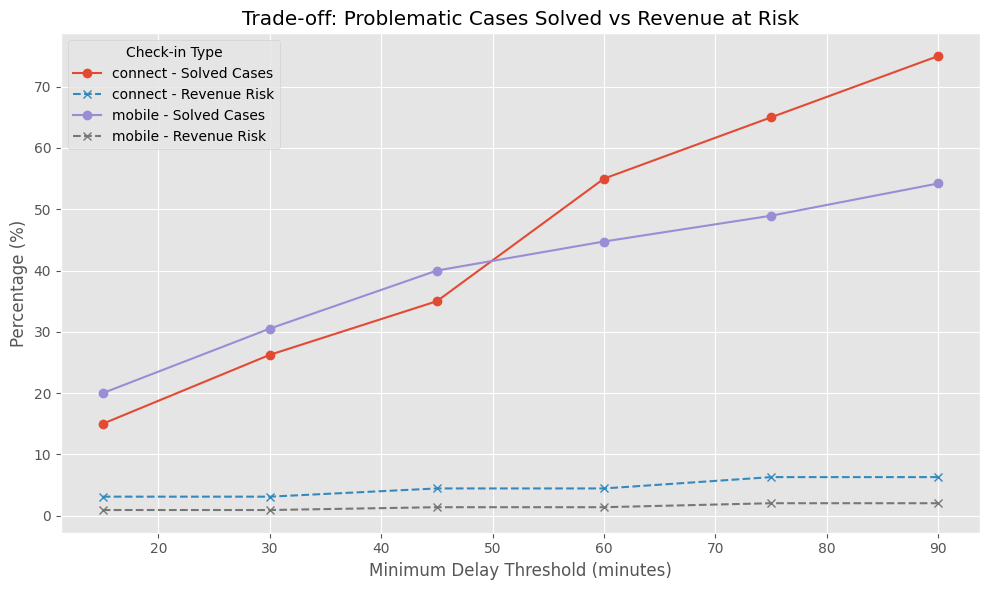

In [ ]:
# Merge solved cases and revenue risk into one comparison DataFrame
comparison_df = pd.merge(
    solved_by_type_df,
    revenue_impact_df,
    on=['checkin_type', 'threshold_minutes'],
    how='inner'
)

# Plot comparison: % Solved vs % Revenue at Risk
plt.figure(figsize=(10, 6))

for checkin_type in comparison_df['checkin_type'].unique():
    subset = comparison_df[comparison_df['checkin_type'] == checkin_type]
    plt.plot(
        subset['threshold_minutes'],
        subset['percent_solved'],
        marker='o',
        label=f'{checkin_type} - Solved Cases')
    plt.plot(
        subset['threshold_minutes'],
        subset['percent_revenue_at_risk'],
        marker='x', linestyle='--',
        label=f'{checkin_type} - Revenue Risk')

plt.title('Trade-off: Problematic Cases Solved vs Revenue at Risk')
plt.xlabel('Minimum Delay Threshold (minutes)')
plt.ylabel('Percentage (%)')
plt.legend(title='Check-in Type')
plt.grid(True)
plt.tight_layout()
plt.show()


Here's the comparison plot showing both sides of the trade-off:

- Solid lines = % of problematic cases solved (good)
- Dashed lines = % of revenue at risk due to blocked rentals (bad)

The plot shows that mobile type offers a better return on increasing the threshold—more problems solved with relatively little revenue at risk. On the otherhand, connect type has fewer issues to solve, but faces a higher percentage of blocked rentals as thresholds increase.

#----- Further analysis to find theright trade-off -----

For each check-in type and threshold, calculate:
- Benefit = % of problematic cases solved
- Cost = % of revenue at risk (blocked rentals)
- Efficiency Score = Benefit / Cost → higher = better trade-off

In [ ]:
# Add efficiency score to the comparison DataFrame
comparison_df['efficiency_score'] = (
    comparison_df['percent_solved'] / comparison_df['percent_revenue_at_risk']
).replace([float('inf')], 0)

# Sort by check-in type and efficiency score descending to identify top trade-offs
best_tradeoffs = comparison_df.sort_values(['checkin_type', 'efficiency_score'], ascending=[True, False])

display(best_tradeoffs)


,checkin_type,threshold_minutes,solved_cases,total_problematic_cases,percent_solved,blocked_rentals,total_rentals,percent_revenue_at_risk,efficiency_score
6,connect,60,44,80,55.00,156,3509,4.45,12.359551
10,connect,90,60,80,75.00,221,3509,6.30,11.904762
8,connect,75,52,80,65.00,221,3509,6.30,10.317460
2,connect,30,21,80,26.25,109,3509,3.11,8.440514
4,connect,45,28,80,35.00,156,3509,4.45,7.865169
0,connect,15,12,80,15.00,109,3509,3.11,4.823151
3,mobile,30,58,190,30.53,135,14536,0.93,32.827957
7,mobile,60,85,190,44.74,202,14536,1.39,32.187050
5,mobile,45,76,190,40.00,202,14536,1.39,28.776978
11,mobile,90,103,190,54.21,297,14536,2.04,26.573529


Above is the cost-benefit analysis, ranked by best efficiency (problems solved per % revenue risk):
For Connect Cars the best balance at 60 minutes solves 55% of issues with 4.45% revenue at risk. 90 minutes solves more (75%) but costs more (6.3% revenue)
while Mobile Cars (in the rest of the table), generally higher efficiency and lower revenue risk at same thresholds.

# ----- Final Threshold Recommendations -----

###1. Connect Cars

In [ ]:
best_connect= best_tradeoffs[best_tradeoffs['checkin_type'] == 'connect']
best_connect

,checkin_type,threshold_minutes,solved_cases,total_problematic_cases,percent_solved,blocked_rentals,total_rentals,percent_revenue_at_risk,efficiency_score
6,connect,60,44,80,55.00,156,3509,4.45,12.359551
10,connect,90,60,80,75.00,221,3509,6.30,11.904762
8,connect,75,52,80,65.00,221,3509,6.30,10.317460
2,connect,30,21,80,26.25,109,3509,3.11,8.440514
4,connect,45,28,80,35.00,156,3509,4.45,7.865169
0,connect,15,12,80,15.00,109,3509,3.11,4.823151


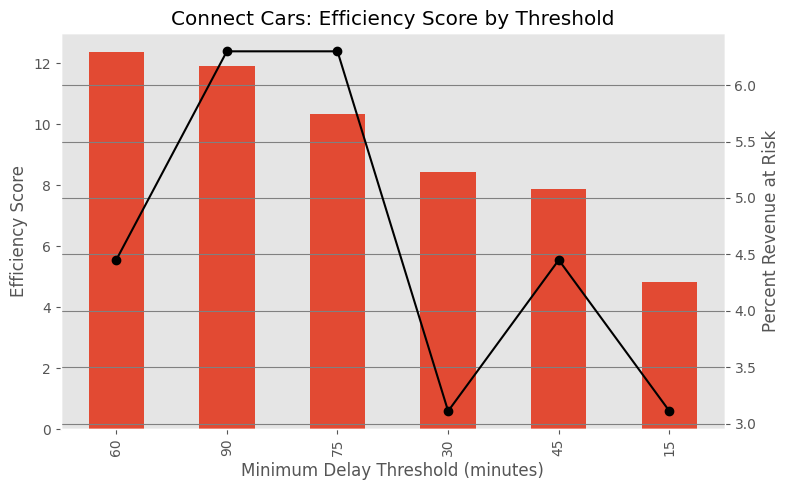

In [ ]:
# Create bar plot
ax = best_connect.plot(
    kind='bar',
    x='threshold_minutes',
    y='efficiency_score',
    legend=False,
    figsize=(8, 5),
    title='Connect Cars: Efficiency Score by Threshold'
)

# Plot the line on the same axes
ax2 = ax.twinx()
ax2.plot(
    ax.get_xticks(),
    best_connect['percent_revenue_at_risk'],
    marker='o',
    linestyle='-',
    label='Percent Revenue at Risk',
    color='black'
)
ax2.set_ylabel('Percent Revenue at Risk')
ax2.grid(color='gray')

# Set axis labels
ax.set_xlabel('Minimum Delay Threshold (minutes)')
ax.set_ylabel('Efficiency Score')
ax.grid(False)


plt.tight_layout()
plt.show()


  -  Based on the efficiency score, the recommended threshold is 60 minutes. Yes, Connect cars rarely have issues (only 80 total problematic overlaps) but 60 minutes is the most efficient threshold. It solved 55% of those rare issues with moderate risk to revenue (4.45% of rentals blocked). Though this result would need further analysis if we had more cases.
  - The 45 minutes threshold is somehow questionable as it's percent_revenue_at_risk is quite high even though  it's just 15-minutes increase from 30 minutes threshold.

  -  We can then argue for a **30-minute threshold** as a lighter-touch policy, solving 26% of issues with only 3.11% revenue risk - a safer, more conservative choice.

###2. Mobile Cars
  - Let’s pull the recommendations for Mobile rentals and let's find the top-options.

In [ ]:
# Filter top-performing options for Mobile check-in type
best_mobile = best_tradeoffs[best_tradeoffs['checkin_type'] == 'mobile']
best_mobile

,checkin_type,threshold_minutes,solved_cases,total_problematic_cases,percent_solved,blocked_rentals,total_rentals,percent_revenue_at_risk,efficiency_score
3,mobile,30,58,190,30.53,135,14536,0.93,32.827957
7,mobile,60,85,190,44.74,202,14536,1.39,32.187050
5,mobile,45,76,190,40.00,202,14536,1.39,28.776978
11,mobile,90,103,190,54.21,297,14536,2.04,26.573529
9,mobile,75,93,190,48.95,297,14536,2.04,23.995098
1,mobile,15,38,190,20.00,135,14536,0.93,21.505376


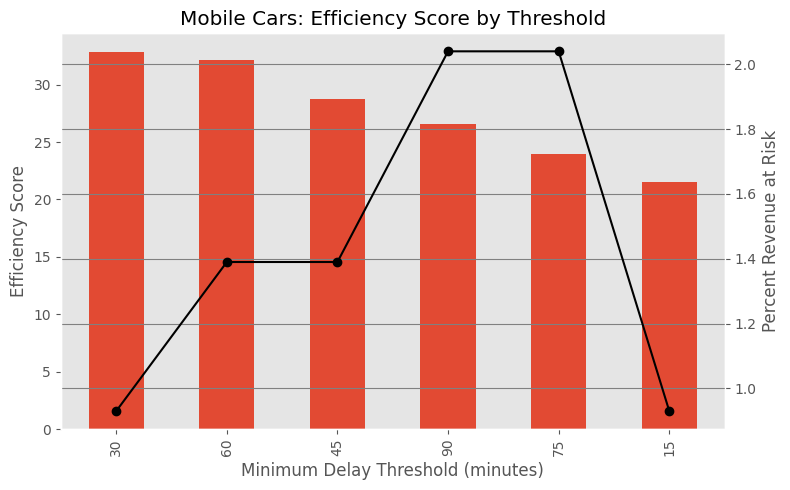

In [ ]:
# Create bar plot
ax = best_mobile.plot(
    kind='bar',
    x='threshold_minutes',
    y='efficiency_score',
    legend=False,
    figsize=(8, 5),
    title='Mobile Cars: Efficiency Score by Threshold'
)

# Plot the line on the same axes
ax2 = ax.twinx()
ax2.plot(
    ax.get_xticks(),
    best_mobile['percent_revenue_at_risk'],
    marker='o',
    linestyle='-',
    label='Percent Revenue at Risk',
    color='black'
)
ax2.set_ylabel('Percent Revenue at Risk')
ax2.grid(color='gray')

# Set axis labels
ax.set_xlabel('Minimum Delay Threshold (minutes)')
ax.set_ylabel('Efficiency Score')
ax.grid(False)


plt.tight_layout()
plt.show()

##Final Recommendation for Mobile Cars
- Recommended Threshold: 30 minutes

Why:
- Solves 31% of problems
- Risks just 0.93% of rental revenue
- Highest efficiency score (33 problems solved per 1% revenue at risk)

This setup gives a balanced and efficient solution, minimizing user friction while preserving most revenue.